In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sqlite3
import statsmodels.api as sm
from lin_reg import best_line

# (1) Business Understanding 

# (2) Data Understanding

In [61]:
# Importing our datasets

tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv.gz')
tmdb_movies = pd.read_csv('data/tmdb.movies.csv.gz')
rt_reviews = pd.read_csv('data/rt.reviews.tsv.gz', sep = '\t', encoding='latin-1')
rt_movie_info = pd.read_csv('data/rt.movie_info.tsv.gz', sep = '\t')
movie_gross = pd.read_csv('data/bom.movie_gross.csv.gz')
conn = sqlite3.connect('data/im.db')

# (3) Data Preparation

## (3.i) TMDB Data

This data comes from The Movie Database (TMDB), which can be accessed [here](https://www.themoviedb.org/?language=en-US).

We can first check out our `tmdb_movies` data using a `.info()` and `.head()`. We can see that we have 26,517 rows to start, with 9 columns of data and an index column. We have some basic information about the film -- notably the name and release date -- as well as some metrics relating to popularity: `popularity`, `vote_average`, `vote_count`. 

In [18]:
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


We'll then do some basic data cleaning. We're eventually going to merge with a few other dataframes using the name of the film, so we're going to preemptively change the `title` column to be named `primary_title`. We'll also drop those columns of data which are unnecessary for our analysis. As we would expect, we still have our 26,517 records.

In [19]:
# Rename the title column to primary_title to match the other dataframes
tmdb_movies.rename(columns={'title': 'primary_title'}, inplace=True)
# Drop the columns that are not needed
tmdb_movies.drop(columns=['genre_ids', 'original_language', 'original_title'], inplace=True)
tmdb_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     26517 non-null  int64  
 1   id             26517 non-null  int64  
 2   popularity     26517 non-null  float64
 3   release_date   26517 non-null  object 
 4   primary_title  26517 non-null  object 
 5   vote_average   26517 non-null  float64
 6   vote_count     26517 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 1.4+ MB


## (3.ii) The Numbers Data
Our next dataset comes from The Numbers, which can be found [here](https://www.the-numbers.com/movie/budgets/all). 

We'll once again start off with a `.info()` and `.head()` so that we can get a sense of what's contained in the data. Here, we get some of our financial information. Specifically, we can see the reported `production_budget` of the movie, along with its `domestic_gross` and `worldwide_gross`. From here, we'll be able to compute a rudimentary (if somewhat flawed) return on investment (ROI) figure. 

In [20]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [21]:
tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


We can also see that the `movie` column corresponds to the name of the film, so we will once again rename that column to `primary_title` so that we can perform merges later. Additionally, the financial columns are formatted as strings rather than integers. We will first strip the dollar signs and commas out of the string and then convert the columns to the integer datatype, so that we can more easily perform our analyses. We also will convert `release_date` to a `datetime` object, and from there extract both the month and year of release, and create the corresponding columns `release_month` and `release_year`.

In [22]:
# Rename the movie column to primary_title to match the other dataframes
tn_movie_budgets.rename(columns={'movie': 'primary_title'}, inplace=True)
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   primary_title      5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [23]:
# Convert the release_date column to a datetime object and create new columns for release_month and release_year
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
tn_movie_budgets['release_month'] = pd.to_datetime(tn_movie_budgets['release_date']).dt.month_name()
tn_movie_budgets['release_year'] = pd.to_datetime(tn_movie_budgets['release_date']).dt.year

In [24]:
# Create a function to allow us to convert the columns to integers
def convert_to_int(df, column):
    df[column] = df[column].str.replace('$', '')
    df[column] = df[column].str.replace(',', '').astype(int)
    return df[column]

# Call the function for our three columns
convert_to_int(tn_movie_budgets, 'domestic_gross')
convert_to_int(tn_movie_budgets, 'worldwide_gross')
convert_to_int(tn_movie_budgets, 'production_budget')

# Check to make sure everything looks alright
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   primary_title      5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   release_month      5782 non-null   object        
 7   release_year       5782 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 361.5+ KB


In [25]:
# We'll also order our months chronologically, so when we plot them, the x
# Axis won't be in alphabetical order.
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
tn_movie_budgets['release_month'] = pd.Categorical(tn_movie_budgets['release_month'], categories=months, ordered=True)
tn_movie_budgets['release_month'].value_counts()

December     745
October      573
August       496
September    493
November     486
June         479
March        470
April        454
July         440
May          407
February     392
January      347
Name: release_month, dtype: int64

### Removing zeroes

Within this dataset, we have a number of films for which there is no reported budget data. Since one of our chief concerns is the financial success of a film, the lack of data on these fronts makes those records useless. 

We first check to make sure that removing the data for which we have no budget information does not throw out an excessive number of records. We go from 5,782 entries to 5,234, so it seems pretty safe to remove the zeroes.

In [26]:
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   primary_title      5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   release_month      5782 non-null   category      
 7   release_year       5782 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 322.4+ KB


In [44]:
tn_movie_budgets[tn_movie_budgets['domestic_gross'] != 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4387 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 4387 non-null   int64         
 1   release_date       4387 non-null   datetime64[ns]
 2   primary_title      4387 non-null   object        
 3   production_budget  4387 non-null   int64         
 4   domestic_gross     3865 non-null   object        
 5   worldwide_gross    4387 non-null   int64         
 6   release_month      4387 non-null   category      
 7   release_year       4387 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(4), object(2)
memory usage: 278.9+ KB


In [45]:
tn_movie_budgets[tn_movie_budgets['domestic_gross'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 0 non-null      int64         
 1   release_date       0 non-null      datetime64[ns]
 2   primary_title      0 non-null      object        
 3   production_budget  0 non-null      int64         
 4   domestic_gross     0 non-null      object        
 5   worldwide_gross    0 non-null      int64         
 6   release_month      0 non-null      category      
 7   release_year       0 non-null      int64         
dtypes: category(1), datetime64[ns](1), int64(4), object(2)
memory usage: 416.0+ bytes


In [46]:
# Since we wouldn't lose too much data, we can drop the zeroes
tn_movie_budgets['domestic_gross'] = tn_movie_budgets[tn_movie_budgets['domestic_gross'] != 0]

In [47]:
tn_movie_budgets[tn_movie_budgets['domestic_gross'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 0 non-null      int64         
 1   release_date       0 non-null      datetime64[ns]
 2   primary_title      0 non-null      object        
 3   production_budget  0 non-null      int64         
 4   domestic_gross     0 non-null      object        
 5   worldwide_gross    0 non-null      int64         
 6   release_month      0 non-null      category      
 7   release_year       0 non-null      int64         
dtypes: category(1), datetime64[ns](1), int64(4), object(2)
memory usage: 416.0+ bytes


One potentially problematic point is the spread of data for the `release_year`. Just from a preliminary look, we can see that there are a handful of films from the very early days of cinema. Since these will likely not have huge bearing on a start-up production company today, and since they constitute a very small proportion of our data, we can go ahead and filter them out. 

Below, you can see the distribution and count for our full dataset. We go from 5234 entries to 3865 entries.

In [30]:
tn_movie_budgets['release_year'].value_counts().sort_index()

1915      1
1916      2
1920      1
1925      2
1927      1
       ... 
2016    219
2017    168
2018    143
2019     67
2020      3
Name: release_year, Length: 96, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   primary_title      5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   release_month      5782 non-null   category      
 7   release_year       5782 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 322.4+ KB


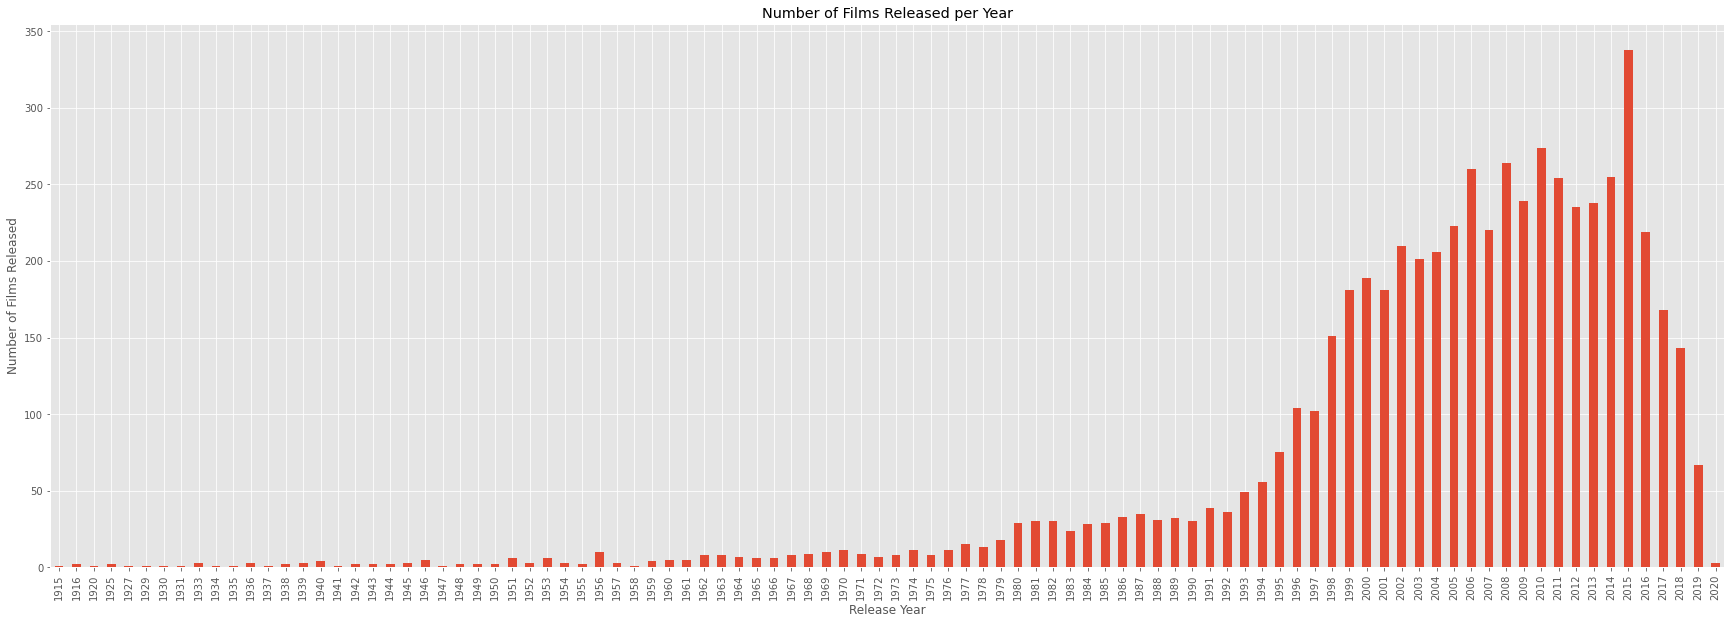

In [34]:
ax1 = plt.subplots(figsize = (30, 10))

ax1 = tn_movie_budgets['release_year'].value_counts().sort_index().plot.bar()
ax1.set_title('Number of Films Released per Year')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('Number of Films Released')

plt.style.use('ggplot')
tn_movie_budgets.info()


This graph justifies our decision to focus only on data from recent films. As the vast majority of films in this dataset are post-2000, we will subset to this period.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4387 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 4387 non-null   int64         
 1   release_date       4387 non-null   datetime64[ns]
 2   primary_title      4387 non-null   object        
 3   production_budget  4387 non-null   int64         
 4   domestic_gross     4387 non-null   int64         
 5   worldwide_gross    4387 non-null   int64         
 6   release_month      4387 non-null   category      
 7   release_year       4387 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 278.9+ KB


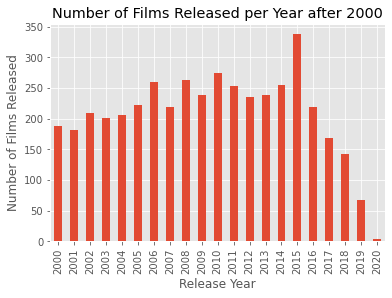

In [35]:
tn_2000 = tn_movie_budgets[tn_movie_budgets['release_year'] >= 2000].copy()

ax2 = tn_2000['release_year'].value_counts().sort_index().plot.bar()
ax2.set_title('Number of Films Released per Year after 2000')
ax2.set_xlabel('Release Year')
ax2.set_ylabel('Number of Films Released')


plt.style.use('ggplot')
tn_2000.info()

In [36]:
# Saving the year filter in place
tn_movie_budgets = tn_movie_budgets[tn_movie_budgets['release_year'] >= 2000].copy()
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4387 entries, 0 to 5781
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 4387 non-null   int64         
 1   release_date       4387 non-null   datetime64[ns]
 2   primary_title      4387 non-null   object        
 3   production_budget  4387 non-null   int64         
 4   domestic_gross     4387 non-null   int64         
 5   worldwide_gross    4387 non-null   int64         
 6   release_month      4387 non-null   category      
 7   release_year       4387 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(5), object(1)
memory usage: 278.9+ KB


### Creating an ROI Column

In [55]:
tn_movie_budgets['domestic_ROI'] = ((tn_movie_budgets['domestic_gross'] - tn_movie_budgets['production_budget']) / tn_movie_budgets['production_budget']) * 100

tn_movie_budgets['worldwide_ROI'] = ((tn_movie_budgets['worldwide_gross'] - tn_movie_budgets['production_budget']) / tn_movie_budgets['production_budget']) * 100

### Removing Budget Outliers

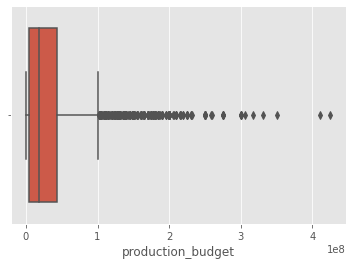

In [56]:
#Boxplot to visualize the outliers
sns.boxplot(x=tn_movie_budgets['production_budget'])
plt.show()

In [58]:
# Calculating the first and third quartiles for production budget
Q1 = tn_movie_budgets['production_budget'].quantile(0.25)
Q3 = tn_movie_budgets['production_budget'].quantile(0.75)

# Calculating the Interquartile Range
IQR = Q3 - Q1

# Getting the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Removing the rows with production budget outliers, saving as a separate df
tn_movie_budgets_no_outliers= tn_movie_budgets.loc[(tn_movie_budgets['production_budget'] >= lower_bound) & (tn_movie_budgets['production_budget'] <= upper_bound)]


## (3.iii) SQL IMDB Database

In [62]:
# Viewing the schema
pd.read_sql('SELECT name AS "Table Names" FROM sqlite_master WHERE type="table"', conn)

,Table Names
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


# Data Analysis

# Conclusion

## Recommendations

## Limitations

## Next Steps